# OUI dataset training

This is the first stage of training. We create a model with the Xception feature extractor as the base, and add layers to build a gender classifier. The training takes place on the OUI dataset, and is then saved for training on DAiSEE in another notebook.

# Imports

In [1]:
#!pip install -r requirements.txt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from tqdm import tqdm

import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.

from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Model, Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

from keras.applications import xception
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# File handling imports
import shutil

In [3]:
# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0: #If you have at least one "configured" GPU, let's use it; otherwise, pass
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Discovered devices: {physical_devices}')

Discovered devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# References:
- https://github.com/zaid478/Transfer-Learning-from-Xception-Model-in-Keras-/blob/master/transfer_learn.py

# Important Config

In [4]:
#load data
fold0 = pd.read_csv("labels/fold_0_data.txt",sep = "\t" )
fold1 = pd.read_csv("labels/fold_1_data.txt",sep = "\t")
fold2 = pd.read_csv("labels/fold_2_data.txt",sep = "\t")
fold3 = pd.read_csv("labels/fold_3_data.txt",sep = "\t")
fold4 = pd.read_csv("labels/fold_4_data.txt",sep = "\t")

In [5]:
total_data = pd.concat([fold0, fold1, fold2, fold3, fold4], ignore_index=True)
print(total_data.shape)
total_data.info()

(19370, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [6]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


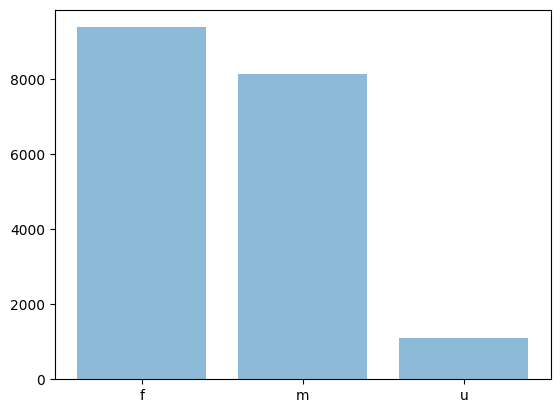

In [7]:
#bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
plt.show()

In [8]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator

In [9]:
from matplotlib import image

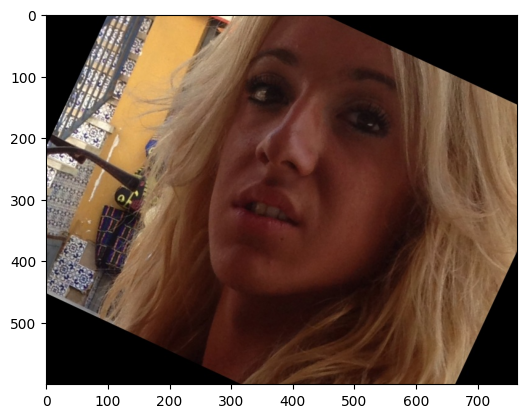

In [10]:
path = "./faces/"+total_data.user_id.loc[0]+"/coarse_tilt_aligned_face."+str(total_data.face_id.loc[0])+"."+total_data.original_image.loc[0]
img = keras.preprocessing.image.load_img(path)
plt.imshow(img)
plt.show()

In [11]:

# img = keras.preprocessing.image.load_img(img_path, target_size=(224, 299, 3))
# array = keras.preprocessing.image.img_to_array(img)

In [12]:
# train_path = 'dataset/Train/'
# test_path = 'dataset/Test/'
image_shape = (224, 299, 3) # HEIGHT, WIDTH, CHANNELS

In [13]:
imp_data = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
imp_data.info()
img_path = []
for row in total_data.iterrows():
    path = "./faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
imp_data['img_path'] = img_path
imp_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
 2   x       19370 non-null  int64 
 3   y       19370 non-null  int64 
 4   dx      19370 non-null  int64 
 5   dy      19370 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 908.1+ KB


,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",f,0,414,1086,1383,./faces/30601258@N03/coarse_tilt_aligned_face....
1,"(25, 32)",m,301,105,640,641,./faces/30601258@N03/coarse_tilt_aligned_face....
2,"(25, 32)",f,2395,876,771,771,./faces/30601258@N03/coarse_tilt_aligned_face....
3,"(25, 32)",m,752,1255,484,485,./faces/30601258@N03/coarse_tilt_aligned_face....
4,"(25, 32)",m,175,80,769,768,./faces/30601258@N03/coarse_tilt_aligned_face....


In [14]:
imp_data = imp_data.dropna()
clean_data = imp_data[imp_data.gender != 'u'].copy()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17492 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17492 non-null  object
 1   gender    17492 non-null  object
 2   x         17492 non-null  int64 
 3   y         17492 non-null  int64 
 4   dx        17492 non-null  int64 
 5   dy        17492 non-null  int64 
 6   img_path  17492 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [15]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}
clean_data['gender'] = clean_data['gender'].apply(lambda g: gender_to_label_map[g])
clean_data.head()

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",0,0,414,1086,1383,./faces/30601258@N03/coarse_tilt_aligned_face....
1,"(25, 32)",1,301,105,640,641,./faces/30601258@N03/coarse_tilt_aligned_face....
2,"(25, 32)",0,2395,876,771,771,./faces/30601258@N03/coarse_tilt_aligned_face....
3,"(25, 32)",1,752,1255,484,485,./faces/30601258@N03/coarse_tilt_aligned_face....
4,"(25, 32)",1,175,80,769,768,./faces/30601258@N03/coarse_tilt_aligned_face....


In [16]:
clean_data

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",0,0,414,1086,1383,./faces/30601258@N03/coarse_tilt_aligned_face....
1,"(25, 32)",1,301,105,640,641,./faces/30601258@N03/coarse_tilt_aligned_face....
2,"(25, 32)",0,2395,876,771,771,./faces/30601258@N03/coarse_tilt_aligned_face....
3,"(25, 32)",1,752,1255,484,485,./faces/30601258@N03/coarse_tilt_aligned_face....
4,"(25, 32)",1,175,80,769,768,./faces/30601258@N03/coarse_tilt_aligned_face....
...,...,...,...,...,...,...,...
19341,"(25, 32)",0,718,748,492,492,./faces/101515718@N03/coarse_tilt_aligned_face...
19342,"(25, 32)",1,48,472,768,768,./faces/101515718@N03/coarse_tilt_aligned_face...
19343,"(25, 32)",0,950,0,692,687,./faces/101515718@N03/coarse_tilt_aligned_face...
19344,"(25, 32)",0,831,895,899,899,./faces/50458575@N08/coarse_tilt_aligned_face....


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
df_Xy = clean_data[['img_path', 'gender']]

In [19]:
df_Xy

,img_path,gender
0,./faces/30601258@N03/coarse_tilt_aligned_face....,0
1,./faces/30601258@N03/coarse_tilt_aligned_face....,1
2,./faces/30601258@N03/coarse_tilt_aligned_face....,0
3,./faces/30601258@N03/coarse_tilt_aligned_face....,1
4,./faces/30601258@N03/coarse_tilt_aligned_face....,1
...,...,...
19341,./faces/101515718@N03/coarse_tilt_aligned_face...,0
19342,./faces/101515718@N03/coarse_tilt_aligned_face...,1
19343,./faces/101515718@N03/coarse_tilt_aligned_face...,0
19344,./faces/50458575@N08/coarse_tilt_aligned_face....,0


In [20]:
Xy_train, Xy_test = train_test_split(
    df_Xy,
    test_size = 0.2, 
    random_state=12345)

In [21]:
#train_df = pd.DataFrame()

In [22]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [23]:
training_generator = image_generator.flow_from_dataframe(
    dataframe=Xy_train,
    directory='./',
    x_col="img_path",
    y_col="gender",
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode='raw'
)

Found 13993 validated image filenames.


In [24]:
validation_generator = image_generator.flow_from_dataframe(
    dataframe=Xy_test,
    directory='./',
    x_col="img_path",
    y_col="gender",
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode='raw'
)

Found 3499 validated image filenames.


In [25]:
import cv2
from PIL import Image

# Train a new Xception model

In [26]:
xception_tl = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=image_shape,
    pooling='max'
)

In [27]:
xception_tl.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [28]:
# Freeze training on all layers
for layer in xception_tl.layers:
    layer.trainable = False

# multi-task model references
https://medium.com/swlh/multi-task-learning-with-tf-keras-5b28dd60246e <br>
https://datascience.stackexchange.com/questions/27498/multi-task-learning-in-keras

In [29]:
# https://keras.io/api/layers/initializers/
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

In [31]:
x = xception_tl.output
#x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='VALID')(x)
x = LayerNormalization()(x)
x = Flatten()(x)

x = Dense(
    512,
    activation='relu',
    name='d1',
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
)(x)

x = Dropout(rate=0.25)(x)

x = Dense(
    512,
    activation='relu',
    name='d2',
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
)(x)

x = Dropout(rate=0.25)(x)

output = Dense(
    2,
    activation='softmax',
    name='cls2_output',
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
)(x)

xception_tl_DAiSEE=Model(inputs=xception_tl.input, outputs=output)

In [32]:
xception_tl_DAiSEE.output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'cls2_output')>

In [33]:
xception_tl_DAiSEE.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 28, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

# Set up for training

In [34]:
%reload_ext tensorboard
model_path = os.path.join('saved_models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_.sav')
log_dir = os.path.join("logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

monitor_accuracy = 'val_accuracy'
monitor_mae = 'val_mean_absolute_error'
monitor_loss = 'val_loss'

tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_cbk = EarlyStopping(monitor=monitor_accuracy, patience=10, verbose=1, mode='max')
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor=monitor_accuracy, mode='max')
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor=monitor_loss, factor=0.1, patience=7, verbose=1, mode='min')
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [35]:
losses = {
    'cls2_output': 'binary_crossentropy'
}
#lossWeights = {"cls2_output": 1.0}

In [36]:
xception_tl_DAiSEE.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    #loss_weights=lossWeights,
    optimizer='adam',
    metrics = ['accuracy','mean_absolute_error']
)

In [37]:
history = xception_tl_DAiSEE.fit(
    training_generator,
    validation_data=validation_generator,
    batch_size=32,
    epochs=50,
    #steps_per_epoch=100, # Set temporarily for frequent validation
    callbacks=callbacks)

Epoch 1/50
438/438 [==============================] - 164s 364ms/step - loss: 2839.0483 - accuracy: 0.6883 - mean_absolute_error: 0.5000 - val_loss: 1113.3608 - val_accuracy: 0.7654 - val_mean_absolute_error: 0.5000 - lr: 0.0010
Epoch 2/50
438/438 [==============================] - 165s 376ms/step - loss: 1468.8741 - accuracy: 0.7372 - mean_absolute_error: 0.5000 - val_loss: 774.4062 - val_accuracy: 0.7785 - val_mean_absolute_error: 0.5000 - lr: 0.0010
Epoch 3/50
438/438 [==============================] - 164s 375ms/step - loss: 1053.4573 - accuracy: 0.7494 - mean_absolute_error: 0.5000 - val_loss: 591.4978 - val_accuracy: 0.7811 - val_mean_absolute_error: 0.5000 - lr: 0.0010
Epoch 4/50
438/438 [==============================] - 167s 380ms/step - loss: 738.1420 - accuracy: 0.7717 - mean_absolute_error: 0.5000 - val_loss: 489.8484 - val_accuracy: 0.7851 - val_mean_absolute_error: 0.5000 - lr: 0.0010
Epoch 5/50
438/438 [==============================] - 167s 380ms/step - loss: 579.2387 -

In [38]:
test_loss, test_acc, *_ = xception_tl_DAiSEE.evaluate(validation_generator, verbose=2)
print(test_acc)

110/110 - 29s - loss: 29.5932 - accuracy: 0.8237 - mean_absolute_error: 0.5000 - 29s/epoch - 261ms/step
0.8236638903617859


# END

In [39]:
xception_tl_DAiSEE.save('OUI_model.h5')